In [1]:
import tensorflow as tf
import numpy as np
!pip install pandas
import pandas as pd
from matplotlib.pyplot import imshow, legend, show
!pip install -q pyyaml h5py
try:
    from keras_lr_finder import LRFinder
except Exception as error:
    !pip install {str(error)[17:-1]}
    from keras_lr_finder import LRFinder
except:
    print("Pacote não encontrado")

print(tf.version.VERSION)

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
2.4.1


In [2]:
lesions = {0: "Basal Cell Carcinoma", 
    1: "Lentigo",
    2: "Malignant Melanoma", 
    3: "Melanocytic naevus",
    4: "seborrhoeic keratosis",
    5: "Wart", 
    6: "Actinic Keratosis",
    7: "Squamous Cell Carcinoma",
    8: "Intraepithelial Carcinoma", 
    9: "Pyogenic Granuloma",
    10: "Haemangioma",
    11: "Dermatofibroma"
}

In [3]:
train = pd.read_csv('train.csv',index_col=0)
test = pd.read_csv('test.csv',index_col=0)
val = pd.read_csv('val.csv',index_col=0)

train_y = train['label'].values
test_y = test['label'].values
val_y = val['label'].values

train.head()

,id,label
0,dataset-split/train/Wart/Wart_original_100.jpg...,5
1,dataset-split/train/Wart/Wart_original_37.jpg_...,5
2,dataset-split/train/Wart/Wart_original_2.jpg_4...,5
3,dataset-split/train/Wart/Wart_original_21.jpg_...,5
4,dataset-split/train/Wart/Wart_original_54.jpg_...,5


In [4]:
df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
df_val = pd.DataFrame(val)

In [5]:
# step 1
train_dataset_filenames = df_train['id'].values.tolist()
train_dataset_labels = df_train['label'].values.tolist()
filenames = tf.constant(train_dataset_filenames)
labels = tf.constant(train_dataset_labels)

# step 2: create a dataset returning slices of `filenames`
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(28)

# step 4: create iterator and final input tensor
iterator_train = tf.compat.v1.data.make_one_shot_iterator(train_dataset)
images_train, labels_train = iterator_train.get_next()

In [6]:
# step 1
val_dataset_filenames = df_val['id'].values.tolist()
val_dataset_labels = df_val['label'].values.tolist()
filenames = tf.constant(val_dataset_filenames)
labels = tf.constant(val_dataset_labels)

# step 2: create a dataset returning slices of `filenames`
val_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

val_dataset = val_dataset.map(_parse_function)
val_dataset = val_dataset.batch(28)

# step 4: create iterator and final input tensor
iterator_val = tf.compat.v1.data.make_one_shot_iterator(val_dataset)
images_val, labels_val = iterator_val.get_next()
print(images_val)

tf.Tensor(
[[[[175. 117.  93.]
   [175. 117.  93.]
   [175. 117.  93.]
   ...
   [ 12.   7.  14.]
   [ 11.   6.  13.]
   [ 10.   5.  12.]]

  [[176. 118.  94.]
   [176. 118.  94.]
   [176. 118.  94.]
   ...
   [ 13.   8.  15.]
   [ 12.   7.  14.]
   [ 12.   7.  14.]]

  [[178. 120.  96.]
   [178. 120.  96.]
   [178. 120.  96.]
   ...
   [ 17.  10.  17.]
   [ 16.   9.  16.]
   [ 16.   9.  16.]]

  ...

  [[211. 153. 129.]
   [211. 153. 129.]
   [211. 153. 129.]
   ...
   [201. 141. 130.]
   [201. 141. 130.]
   [201. 141. 130.]]

  [[211. 153. 129.]
   [211. 153. 129.]
   [211. 153. 129.]
   ...
   [201. 141. 130.]
   [201. 141. 130.]
   [201. 141. 130.]]

  [[211. 153. 129.]
   [211. 153. 129.]
   [211. 153. 129.]
   ...
   [201. 141. 130.]
   [201. 141. 130.]
   [201. 141. 130.]]]


 [[[131.  97.  69.]
   [127.  93.  65.]
   [139. 105.  77.]
   ...
   [158. 119.  86.]
   [161. 122.  89.]
   [167. 128.  95.]]

  [[139. 105.  77.]
   [133.  99.  71.]
   [140. 106.  78.]
   ...
   [164. 1

In [7]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     for gpu in gpus:
#         tf.config.experimental.set_memory_growth(gpu, True)

In [8]:
numpy_images = []
numpy_labels = []
for images, labels in train_dataset.take(500): # only take first element of dataset
    numpy_images.append(images.numpy())
    numpy_labels.append(labels.numpy())

In [9]:
x = np.concatenate(numpy_images, axis=0)
y = np.concatenate(numpy_labels, axis=0)


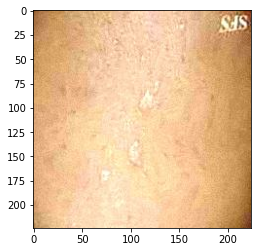

In [10]:
imshow(tf.cast(images_val[5], tf.uint8))

In [11]:
model = tf.keras.applications.ResNet152(weights=None)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
# model.summary()
lr_finder = LRFinder(model)
lr_finder.find(x, y, start_lr=0.0001, end_lr=1, batch_size=28, epochs=5)
# history = model.fit(train_dataset, epochs=25, 
#                     validation_data=val_dataset)

Epoch 1/5
500/500 [==============================] - 279s 529ms/step - loss: 1.2731 - accuracy: 0.6911
Epoch 2/5
500/500 [==============================] - 265s 529ms/step - loss: 0.4982 - accuracy: 0.8396
Epoch 3/5
500/500 [==============================] - 265s 529ms/step - loss: 0.5027 - accuracy: 0.8369
Epoch 4/5
500/500 [==============================] - 265s 529ms/step - loss: 0.6508 - accuracy: 0.7806
Epoch 5/5
500/500 [==============================] - 92s 183ms/step - loss: 1.2269 - accuracy: 0.6947


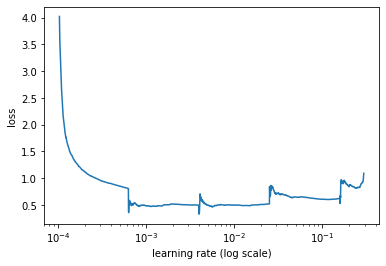

In [12]:
lr_finder.plot_loss()

In [ ]:
y = np.concatenate([y for x, y in train_dataset], axis=0)
x = np.concatenate([x for x, y in train_dataset], axis=0)
print(y)

In [ ]:
print(x)